In [1]:
import numpy as np
import random

random.seed(100)

def compute_pi(num_samples, num_bins = 20):
    results = []
    counter = 0

    for ib in range(num_bins):
        counter = 0
        for i in range(num_samples):
             x = 2 * random.random() - 1.0
             y = 2 * random.random() - 1.0
             r = x**2 + y**2
             if r <= 1.0:
                counter += 1
        results.append(((4.*counter)/num_samples))
   
    return np.average(results), np.std(results)

for num_samples in [10**2, 10**3, 10**4, 10**5, 10**6]:
    av,err = compute_pi(num_samples)
    print(av, err, np.abs(av-np.pi))
    
    
#plt.errorbar(num_samples_list, data[:,0], data[:,1])
plt.plot(num_samples_list, data[:,1], marker="o")
plt.xscale("log")
plt.yscale("log")
plt.plot(num_samples_list, 1/np.array(num_samples_list, dtype=float)**0.5)

plt.xlabel("Number of samples")
plt.ylabel("Error bars")
plt.tight_layout()
plt.savefig("error.pdf")
    

3.142 0.110616454472 0.000407346410207
3.1392 0.0431666537967 0.00239265358979
3.14898 0.0196653909191 0.00738734641021
3.140668 0.00458125048431 0.000924653589793
3.1416988 0.00173655111068 0.000106146410207


array([ 0.,  1.,  2.])

In [20]:
printA()

A


In [17]:
import numpy as np
import random
#from abc import abstractmethod

class MonteCarloSampler:
    def __init__(self):
        self.results = []
    
    def perform(self):
        #do nothing
        print("Should not be called")
        
    def get_results(self):
        if len(self.results) == 0:
            print("No available results found")
            return 0.0
        return np.average(self.results)
    
    def reset(self):
        self.results = []

class SimpleMonteCarloSampler(MonteCarloSampler):
    def __init__(self):
        super().__init__()
        
    def perform(self):
        counter = 0
        num_samples = 10**3
        for i in range(num_samples):
            x = 2 * random.random() - 1
            y = 2 * random.random() - 1
            if x**2 + y**2 < 1:
                counter += 1
        self.results.append(4*counter/num_samples)

#class FastMonteCarloSampler(MonteCarloSampler):
#    def perform(self):
        #"""""******"""

mc = SimpleMonteCarloSampler()
mc.perform()

for i in range(10):
    mc.perform()
    print(mc.get_results())

mc.reset()
mc.perform()
print(mc.get_results())

3.124
3.104
3.079
3.0872
3.09733333333
3.11142857143
3.118
3.11733333333
3.1204
3.12436363636
3.28


In [10]:
import numpy as np
import random
import copy

class MonteCarloSampler:
    def __init__(self, params):
        self.results = {}
        self.params = copy.copy(params)
        self.Jij = copy.copy(self.params["Jij"])
        self.h = self.params["h"]
        self.beta = self.params["beta"]
        self.Ns = self.params["Ns"]
        
    def perform(self):
        #do nothing

        
        #Various checks
        
        #All spins are pointing upward
        Sz = np.array([1]*Ns)
        print("Initial energy is ", calc_energy(Sz))
        
        #E = -h * Sz
#        n_sample = self.params["n_steps"]
#        Es = np.zeros(n_sample, dtype=float)
#        Szs = np.zeros(n_sample, dtype=float)
#        Sz2s = np.zeros(n_sample, dtype=float)
#        for isample in range(n_sample):
#            Pu = np.exp(beta*h)/(np.exp(beta*h) + np.exp(beta*-h))
#            if random.random() < Pu:
#                Sz = 1
#            else:
#                Sz = -1
#            E = - h * Sz
#            Szs[isample] = Sz
#            Sz2s[isample] = Sz**2
#            Es[isample] = E
            
        #compute results
#       if h != 0:
#            self.results["chi"] = np.average(Szs)/h
#        else:
#            self.results["chi"] = beta * np.average(Sz2s)

    def calc_energy(self, Sz):
        E = 0.0
        for i in range(self.Ns):
            for j in range(self.Ns):
                E += 0.5 * self.Jij[i,j] * Sz[i] * Sz[j]
            E += - self.h * Sz[i]
        return E
    
    def get_results(self):
        return self.results
    
    def reset(self):
        self.results = []

p = {"h" : 0.0, "Ns" : 10, "beta" : 10.0}
p["h"] = 0.0
for T in [0.01, 0.1, 1]:
    p["beta"] = 1/T
    p["n_steps"] = 1000000
    mc = MonteCarloSampler(p)
    mc.perform()
    r = mc.get_results()
    print(1/T, r["chi"])

p["h"] = 0.005
for T in [0.01, 0.1, 1]:
    p["beta"] = 1/T
    p["n_steps"] = 1000000
    mc = MonteCarloSampler(p)
    mc.perform()
    r = mc.get_results()
    print(1/T, r["chi"])



100.0 100.0
10.0 10.0
1.0 1.0
100.0 92.2548
10.0 9.7176
1.0 1.0816


In [1]:
import numpy as np
import random
import copy
import sys
import time
from numba import jit

def find_connection(Jij):
    connected_list = []
    Ns = Jij.shape[0]
    assert Jij.shape[0] == Jij.shape[1]
    tmp_array2 = np.zeros((Ns,), dtype=int)
    for isite in range(Ns):
        tmp = []
        for jsite in range(Ns):
            if Jij[isite, jsite] != 0.0:
                tmp.append(jsite)
        tmp_array2[isite] = len(tmp)
        connected_list.append(tmp)

    z = np.amax(tmp_array2)
    tmp_array = np.zeros((Ns, z), dtype=int)
    for isite in range(Ns):
        for j in range(len(connected_list[isite])):
            tmp_array[isite, j] = connected_list[isite][j]
    return tmp_array, tmp_array2

@jit(nopython=True)
def perform_one_sweep(Ns, beta, h, connection, coord_num, Jij, Sz):
        #z = connection.shape[1]
        dE_tot = 0.0
        for iupdate in range(Ns):
            #Select a site randomly
            isite = random.randint(0, Ns-1)
            
            #Compute the relative energy of the candidate
            dE = - h
            for j in range(coord_num[isite]):
                dE += Jij[isite, connection[isite,j]] * Sz[connection[isite,j]]
            dE *= -2 * Sz[isite]
            
            prob = 0.0
            if beta*dE < -50:
                prob = 1.0
            elif beta*dE > 50:
                prob = 0.0
            else:
                prob = np.exp(-beta*dE)/(1+np.exp(-beta*dE))
                    
            if prob > random.random():
                Sz[isite] *= -1
                dE_tot += dE
        return dE_tot

class SblMagEstimator:
    def __init__(self, coeff):
        self.coeff = copy.copy(coeff)
    
    def compute(self, Sz, E):
        return (np.dot(self.coeff, Sz)).real/len(self.coeff)
    
class MonteCarloSampler:
    def __init__(self, params):
        self.results = {}
        self.params = copy.copy(params)
        self.Jij = copy.copy(self.params["Jij"])
        self.h = self.params["h"]
        self.beta = self.params["beta"]
        self.Ns = self.params["Ns"]
        self.connection, self.coord_num = find_connection(self.Jij)
        self.sbl_mag = copy.copy(self.params["sbl mag"])
        assert self.sbl_mag.shape[1] == self.Ns
        self.obs = []
    
    def add_observable(self, name, estimator):
        self.obs.append((name,copy.copy(estimator)))
        
    def perform_fast(self):
        #All spins are pointing upward
        Sz = np.zeros((Ns,), dtype=int)
        Sz[:] = 1
        E = self.calc_energy(Sz)
        #print("Initial energy ", E)
        n_sample = self.params["n_steps"]
        Es = np.zeros(n_sample, dtype=float)
        Mvec = np.zeros(n_sample, dtype=float)
        M2vec = np.zeros(n_sample, dtype=float)
        nsblmag = self.sbl_mag.shape[0]
        sblmagvec = np.zeros((n_sample, nsblmag), dtype=float)
        n_obs = len(self.obs)
        obsvec = np.zeros((n_sample, n_obs), dtype=float)
 
        #print(sblmagvec.shape)

        # Thermalization
        for isample in range(int(n_sample/10)):
            E += perform_one_sweep(self.Ns, self.beta, self.h, self.connection, self.coord_num, self.Jij, Sz)

        # Measurements
        for isample in range(n_sample):
            E += perform_one_sweep(self.Ns, self.beta, self.h, self.connection, self.coord_num, self.Jij, Sz)
            Es[isample] = E
            
            M = np.sum(Sz)
            Mvec[isample] = M
            M2vec[isample] = M**2
            for isbl in range(nsblmag):
                sblmagvec[isample, isbl] = (np.dot(self.sbl_mag[isbl,:], Sz)).real
            for iobs in range(n_obs):
                obsvec[isample, iobs] = self.obs[iobs][1].compute(Sz, E)
            
        #compute results
        if self.h != 0:
            self.results["chi"] = np.average(M2vec)/(h * self.Ns)
        else:
            self.results["chi"] = self.beta * (np.std(Mvec)**2) /self.Ns
            
        self.results["C"] = self.beta * (np.std(Es)**2)/self.Ns
        self.results["sbl mag"] = self.beta * (np.std(sblmagvec, axis=0)**2)/self.Ns
    
        for iobs in range(n_obs):
            self.results[self.obs[iobs][0]+"_average"] = np.average(obsvec[:,iobs])
            self.results[self.obs[iobs][0]+"_std"] = np.std(obsvec[:,iobs])
                        
    def calc_energy_slow(self, Sz):
        E = 0.0
        for i in range(self.Ns):
            for j in range(self.Ns):
                E += 0.5 * self.Jij[i,j] * Sz[i] * Sz[j]
            E += - self.h * Sz[i]
        return E
    
    def calc_energy(self, Sz):
        E = 0.0
        for i in range(self.Ns):
            for k in range(self.coord_num[i]):
            #for j in self.connection[i]:
                j = self.connection[i,k]
                E += 0.5 * self.Jij[i,j] * Sz[i] * Sz[j]
            E += - self.h * Sz[i]
        return E
    
    def get_results(self):
        return self.results
    
    def reset(self):
        self.results = []

L = 20
Ns = L**2
params = {"h" : 0.0, "Ns" : Ns}
J = 1.0
Jij = np.zeros((Ns, Ns), dtype=float)

#Figure out how the sites are labeled
lidx_map = {}
dr_list = [[0,0], [L,0], [-L,0], [0,L], [0,-L]]
for ix in range(L):
    for iy in range(L):
        p = ix * L + iy
        for dr in dr_list:
            lidx_map[(ix+dr[0],iy+dr[1])] = p

NN_list = [[1,0], [-1,0], [0,1], [0,-1]]
for ix in range(L):
    for iy in range(L):
        for nn in NN_list:
            Jij[lidx_map[(ix+nn[0], iy+nn[1])], lidx_map[(ix,iy)]] = J
params["Jij"] = np.array(Jij)

phase = np.zeros((1,Ns), dtype=complex)
for ix in range(L):
    for iy in range(L):
        phase[0, ix * L + iy] = (-1)**(ix + iy)
params["sbl mag"] = phase

sblmag_est = SblMagEstimator(phase)

t = time.time()
results = []
for T in np.linspace(1.5, 3.0, 21):
    params["beta"] = 1/T
    params["n_steps"] = 100000
    mc = MonteCarloSampler(params)
    mc.add_observable("sbl_mag_new", sblmag_est)
    mc.perform_fast()
    r = mc.get_results()
    r["params"] = copy.copy(params)
    results.append(r)
    #print(T, r["chi"], r["C"], r["sbl mag"])
    print(T, r["chi"], r["C"], r["sbl mag"], r["sbl_mag_new_std"])             
print(time.time()-t)



1.5 0.0131285205167 0.296671837696 [ 0.02723414] 4.04233674951
1.575 0.0163374013333 0.388145163825 [ 0.03963468] 4.99698384804
1.65 0.0197624819976 0.491072045421 [ 0.05272755] 5.8991680151
1.725 0.0237781709212 0.628018183782 [ 0.07637536] 7.25940735518
1.8 0.0277753733061 0.782867965047 [ 0.10919228] 8.86670422917
1.875 0.0325057531221 1.00729115665 [ 0.17135194] 11.3363995807
1.95 0.0378970653846 1.27090903138 [ 0.31807013] 15.7510223115
2.025 0.0432494525314 1.56039998818 [ 0.42286575] 18.5073299105
2.1 0.0496048373333 2.10248092148 [ 1.4302422] 34.6612672455
2.175 0.0572462675306 2.82155037124 [ 119.63256238] 322.614831141
2.25 0.0655710189227 3.44103231437 [ 97.80549544] 296.689982798
2.325 0.0750152535811 3.82243475093 [ 53.11773075] 222.259959495
2.4 0.0842049360996 3.253115706 [ 41.57711319] 199.784956049
2.475 0.0895167562731 2.66605237124 [ 26.16973552] 160.959740834
2.55 0.0936101953114 2.14121667834 [ 16.78049879] 130.828547199
2.625 0.0973181823356 1.83036278043 [ 12.102

In [12]:
from numba.decorators import jit
import time

import numpy as np

@jit
def compute_sum(x):
    l = 
    N = len(x)
    #rtmp = 0.0
    for i in range(N):
        #rtmp += x[i]
        l.append(x)
    return l

x = np.zeros(1000000)
t = time.time()
print(compute_sum(x))
#print(np.sum(x))
print(time.time()-t)

SyntaxError: invalid syntax (<ipython-input-12-2f7d234e0765>, line 8)

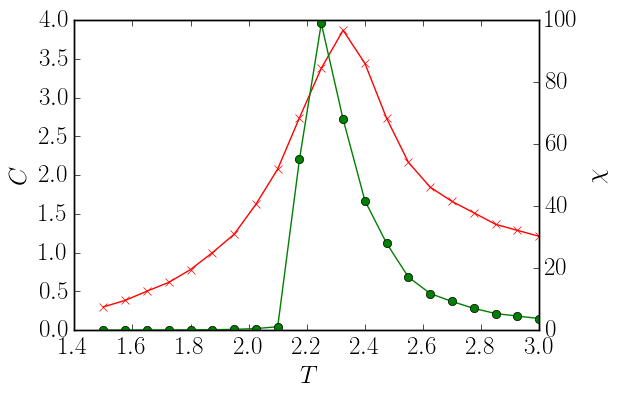

In [17]:
import matplotlib.pylab as plt
%matplotlib inline

x = []
y = []
y2 = []
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
for r in results:
    x.append(1/(r["params"]["beta"]))
    y.append(r["C"])
    y2.append(r["sbl mag"][0])

ax1.plot(x, y, marker='x', color='r')
ax2.plot(x, y2, marker='o', color='g')
ax1.set_xlabel("$T$")
ax1.set_ylabel("$C$")
ax2.set_ylabel("$\chi$")